In [1]:

import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.animation as animation
import matplotlib.colors as colors
import animatplot as amp
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time
import convert

# plt.rcParams.update({'font.size': 22})

In [2]:
data = simplesim.Manager( directory="./resistivity-new-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-new-diag", filetype="nc")

In [3]:
content = diag.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for pp in content:
 
    print( diag.outfile( pp), " split into ", diag.count( pp), " file(s)", i,
          "tau", pp["physical"]["tau"], "res", pp["physical"]["resistivity"])
    i+=1

The database contains 12 simulations
resistivity-new-diag/1f1ab687243422011a4b80ed9684a5e0cd49477a.nc  split into  7  file(s) 0 tau 0 res 1e-05
resistivity-new-diag/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.nc  split into  7  file(s) 1 tau 1 res 3e-06
resistivity-new-diag/3ec81972a93bd5b7efb96fff8f32a128e879b6ea.nc  split into  10  file(s) 2 tau 1 res 0.0001
resistivity-new-diag/5a1869d7ed70394c1bd05e9c610623517269179d.nc  split into  7  file(s) 3 tau 0 res 3e-06
resistivity-new-diag/7f852ba3d56765383228e963268ee9593583c96e.nc  split into  9  file(s) 4 tau 0 res 0.0001
resistivity-new-diag/8ff727a75b374aeb38e1093af32542ef213cc1fe.nc  split into  10  file(s) 5 tau 1 res 0.0003
resistivity-new-diag/a658b772ad9f39a9a2e6a026c0c6db8cd0177299.nc  split into  7  file(s) 6 tau 1 res 1e-06
resistivity-new-diag/a9c2c59b90af00fe9a0ecc143e930168a528f06e.nc  split into  10  file(s) 7 tau 1 res 3e-05
resistivity-new-diag/bb9743ce9505b22bf7474671f3ecef8a340e83bf.nc  split into  7  file(s) 8 tau 1 res 

In [4]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
i = 0
for pp in content :
    print(i, pp['physical']['resistivity'], pp['physical']['tau'])
    i = i+1

0 1e-06 0
1 1e-06 1
2 3e-06 0
3 3e-06 1
4 1e-05 0
5 1e-05 1
6 3e-05 0
7 3e-05 1
8 0.0001 0
9 0.0001 1
10 0.0003 0
11 0.0003 1


In [5]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [6]:
# for file in content :
pp = content[9]
da = create_merged_dataset( data, pp)
ds = create_merged_dataset( diag, pp)
print( da.physical["resistivity"], da.physical['tau'])
lvls=da.boundary["wall"]["boundary"]
print( "Wall levels = ", lvls)

/home/matthias/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


0.0001 1
Wall levels =  [1.15, 0.97]


In [7]:
Z = da['yc'][0,0,:,:]
rhop = da['Rho_p'][0,:,:]
Z

<xarray.DataArray 'yc' (y: 504, x: 288)>
dask.array<getitem, shape=(504, 288), dtype=float64, chunksize=(504, 288), chunktype=numpy.ndarray>
Coordinates:
    z        float64 0.09817
  * y        (y) float64 -432.6 -430.7 -428.8 -427.6 ... 388.3 389.4 391.3 393.2
  * x        (x) float64 291.8 293.7 295.6 296.7 ... 758.3 759.4 761.3 763.2
    time     float64 0.0
Attributes:
    long_name:  y-coordinate in Cartesian coordinate system

In [8]:
da.source

{'damping': {'alpha': 0.2, 'boundary': 0.55, 'type': 'alignedX'},
 'minalpha': 0.05,
 'minne': 0.2,
 'minrate': 1.0,
 'ntilde': {'type': 'zero'},
 'profile': {'background': 0.0,
  'npeak': 1.0,
  'nsep': 0.11764705882352941,
  'type': 'aligned'},
 'rate': 0.0001,
 'type': 'influx'}

In [9]:
# # # This is how convert works 
# my_cmap = convert.xml2cmap( 'colormap.xml')
# my_cmap

In [10]:
# Sample a colormap out of two maps
# colors1 = plt.cm.magma(np.linspace(0., 0.8, 128))
# colors1 = plt.cm.magma(np.linspace(0.2, 0.7, 128))
# colors2 = plt.cm.magma(np.linspace(0.1, 1, 128))
# colors1 = plt.cm.magma_r(np.linspace(0.0, 0.75, 128))

colors1 = plt.cm.binary(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0.0, 1, 128))
# combine them and build a new colormap
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('RedGray', mycolors)
# cmap = plt.get_cmap('twilight_shifted')
# cmap = plt.get_cmap('bone_r')
# cmap = plt.get_cmap('twilight')
cmap.set_bad('white')
# cmap.set_bad('black')
plt.register_cmap('RedGray',cmap)
colors1 = plt.cm.bone_r(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.magma_r(np.linspace(0.0, 1, 128))
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('MagmaBone', mycolors)
plt.register_cmap('MagmaBone',cmap)
colors1 = plt.cm.bone_r(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.bone_r(np.linspace(0.0, 1, 128))
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('MagmaBone', mycolors)
plt.register_cmap('BoneBone',cmap)


In [11]:
color = "bone"
convert.cmap2xml(plt.get_cmap( color),filename=color+".xml")

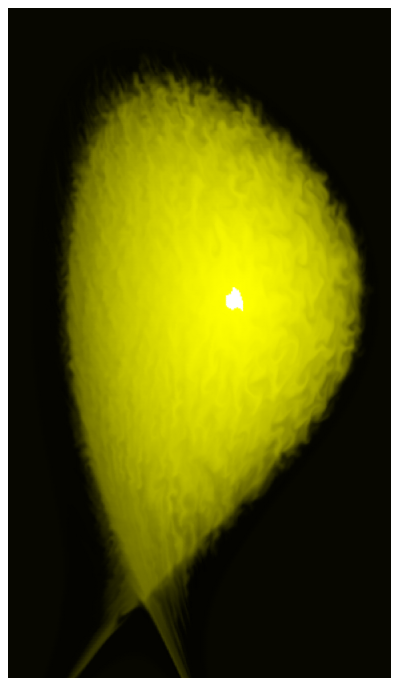

In [12]:
%matplotlib inline
nrows = 1
ncols = 1
fig,ax=plt.subplots(nrows, ncols,figsize=(ncols*3*3,nrows*3*3.7),dpi= 80, facecolor='w', edgecolor='k')
data = da['electrons_2d'][-1,:,:]
cmap = convert.xml2cmap( 'FloatPNG_PV44.xml')
# cmap = plt.get_cmap( 'bone_r').copy()
# cmap.set_bad('black')
norm = colors.LogNorm()
#     norm = colors.TwoSlopeNorm( vmin=0.2, vcenter=1, vmax=7)
#     norm = colors.Normalize( vmin = 0.2, vmax = 12)
pcm = ax.pcolormesh( da['x'], da['y'], data,
                norm=norm,
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
                rasterized=True)
ax.set_aspect('equal')
plt.axis('off')
plt.savefig( "electrons_2d_colormoves.png",bbox_inches='tight')
plt.show()

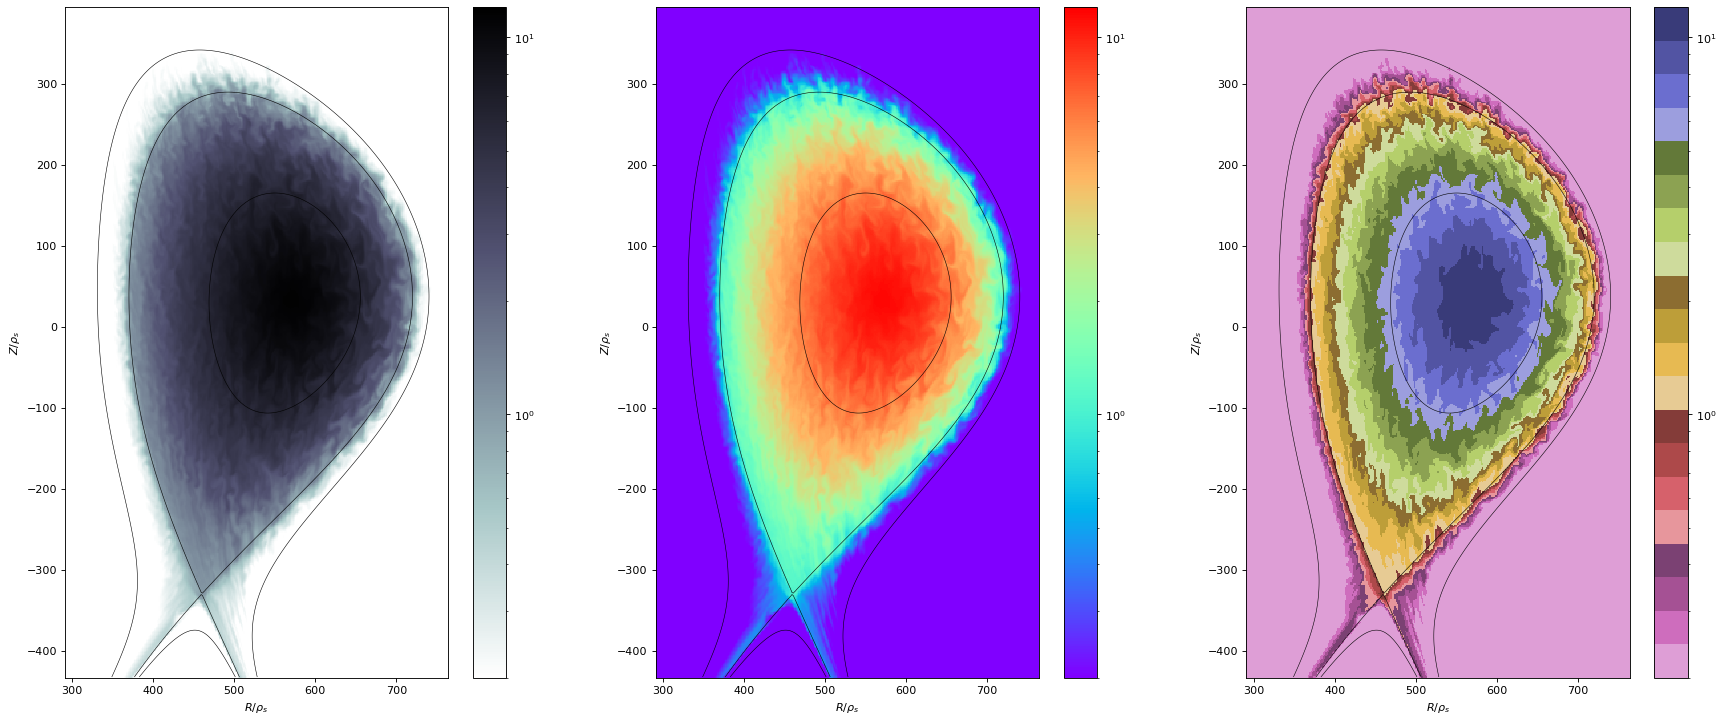

In [13]:
# dark-is-more bias
# artificially extend RAM? to plot 
# fix contours
%matplotlib inline
nrows = 1
ncols = 3
idx = 0
fig,axi=plt.subplots(nrows, ncols,figsize=(ncols*3*3,nrows*3*3.7),dpi= 80, facecolor='w', edgecolor='k')
data = da['electrons_2d'][-1,:,:]
rhop = da['Rho_p'][0,:,:]
Z = da['zc'][0,0,:,:]
for color in ['bone_r','rainbow','tab20b_r'] :
    ax = axi[idx]

    # data = np.ma.masked_where( (rhop>1.15) | (  (rhop<0.97) & (Z < -350)), data)
    # data=np.ma.masked_where( data<0.21, data)

    cmap = plt.get_cmap( color).copy()
    cmap.set_bad('white')
    # cmap.set_bad('black')
    norm = colors.LogNorm(vmin = 0.2, vmax = 12)
#     norm = colors.TwoSlopeNorm( vmin=0.2, vcenter=1, vmax=7)
#     norm = colors.Normalize( vmin = 0.2, vmax = 12)
    pcm = ax.pcolormesh( da['x'], da['y'], data,
                    norm=norm,
                    shading='auto', # more pixely
    #                 shading='gouraud',
                    cmap=cmap,
                    rasterized=True)
    im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                    levels=[1,lvls[0]], linewidths=.5,colors='k')
    im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                    levels=[lvls[1]], linewidths=.5,colors='k')
    im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                    levels=[da.source['damping']['boundary']], linewidths=.5,colors='k')
    ax.set_aspect('equal')
    ax.set_xlabel( r"$R/\rho_s$")
    ax.set_ylabel( r"$Z/\rho_s$")
    fig.colorbar(pcm, ax=ax,)
    idx = idx+1
plt.show()


In [14]:
# da.feltor.animate_list(
#     variables=[da['electrons_2d'],da['Ue_2d'],da['Ui_2d'],da['vorticity_2d']],
#     aspect="equal", fps=10000
# )


# xvals = da['x']
# yvals = da['y']
# vals = da['electrons_2d'].values
# blocks = amp.blocks.Pcolormesh( xvals, yvals, vals, ax = ax,
#                                vmin = 0, vmax = 10,
#                                shading='gouraud', cmap='jet',rasterized=True)
# t_values = da["time"]/1000
# timeline = amp.Timeline( t_values, fps = 50)
# anim = amp.Animation( [blocks], timeline, fig)
# plt.show()
# anim.controls()
# anim.save_gif("test")

In [15]:
# convert to mp4 with 
#https://unix.stackexchange.com/questions/40638/how-to-do-i-convert-an-animated-gif-to-an-mp4-or-mv4-on-the-command-line
#ffmpeg -i animated.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4

In [16]:
da.time.attrs['units'] = r"$\Omega_{ci}^{-1}$"
da.time

<xarray.DataArray 'time' (time: 1001)>
array([     0.,    100.,    200., ...,  99800.,  99900., 100000.])
Coordinates:
  * time     (time) float64 0.0 100.0 200.0 300.0 ... 9.98e+04 9.99e+04 1e+05
Attributes:
    units:    $\Omega_{ci}^{-1}$

In [17]:
# %matplotlib notebook
# fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

# # norm = colors.TwoSlopeNorm( vmin=0.2, vcenter=1, vmax=7)
# # cmap = plt.get_cmap( 'continuous-tab20b').copy()
# norm = colors.Normalize( vmin = 0.2, vmax = 7)
# cmap = plt.get_cmap( 'bone_r').copy()
# anim = da["electrons_2d"][:,:,:].feltor.animate2D(
#     x="x", y="y",ax = ax, fps=50,
#     shading='auto', norm=norm, cmap=cmap, extend='max', controls='timeline'
# )

# # print(da["Rho_p"])
# im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
#                 levels=[1,lvls[0]], linewidths=.5,colors='k')
# im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
#                 levels=[lvls[1]], linewidths=.5,colors='k')
# im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
#                 levels=[da.source['damping']['boundary']], linewidths=.5,colors='k')
# ax.set_aspect('equal')
# ax.set_xlabel( r"$R/\rho_s$")
# ax.set_ylabel( r"$Z/\rho_s$")

# anim.save( "ne_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))


In [18]:
# cmap = convert.xml2cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml')
# cmap

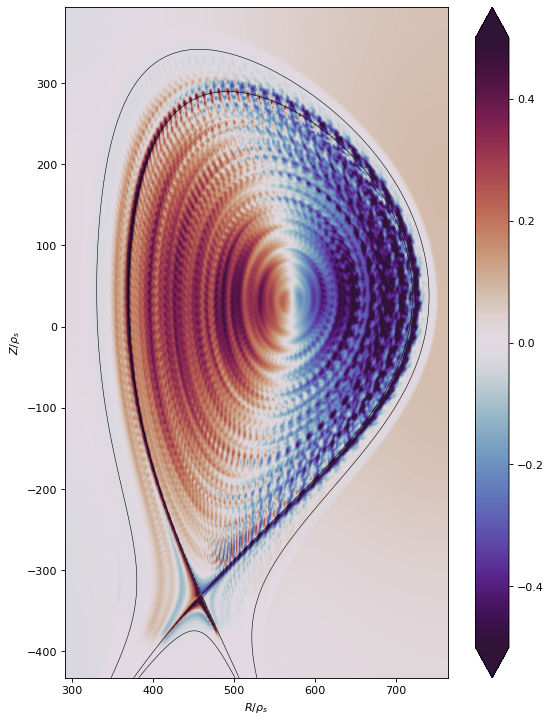

In [19]:
# Plotting Current
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

cmap=plt.get_cmap('twilight_shifted')
# cmap=plt.get_cmap('seismic')
# cmap = convert.xml2cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
# cmap = convert.xml2cmap( 'ccc-tool_colormap_Divergent 1.xml')

pcm = ax.pcolormesh( da['x'], da['y'], da['niui_ta2d'][-1,:,:]-da['neue_ta2d'][-1,:,:],
                    vmin=-0.5,vmax=0.5,
#                 norm=colors.CenteredNorm(),
#                 norm=colors.SymLogNorm(linthresh=0.4, linscale=.1,
#                                               vmin=-0.2, vmax=0.2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax,extend='both')
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

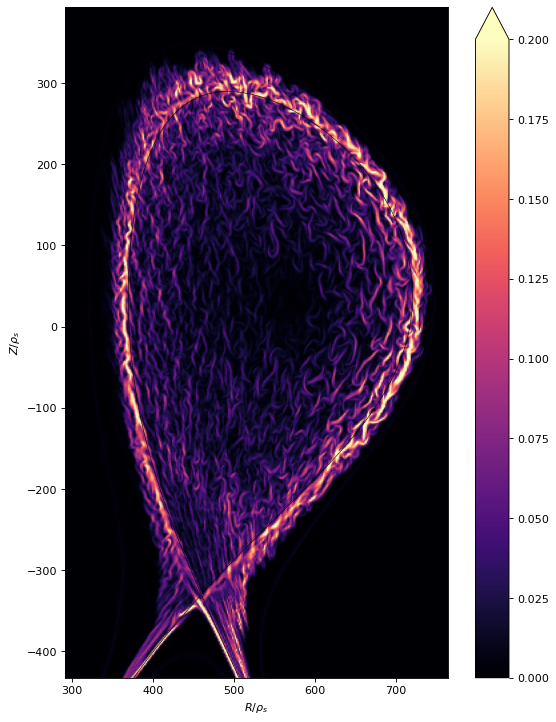

In [20]:
# Plotting Current
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

cmap=plt.get_cmap('hot')
# cmap=plt.get_cmap('seismic')
# cmap = convert.xml2cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
# cmap = convert.xml2cmap( 'ccc-tool_colormap_Divergent 1.xml')
cmap = plt.get_cmap( 'magma')
# pcm = ax.pcolormesh( da['x'], da['y'], ds['vorticity_cta2d'][-1,:,:],
pcm = ax.pcolormesh( da['x'], da['y'], da['lperpinv_2d'][-1,:,:],
                    vmin=0.,vmax=0.2,
#                     vmin=0,vmax=0.00051,
#                 norm=colors.CenteredNorm(),
#                 norm=colors.SymLogNorm(linthresh=0.001, linscale=.5,
#                                               vmin=-0.2, vmax=0.2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax,extend='max')
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

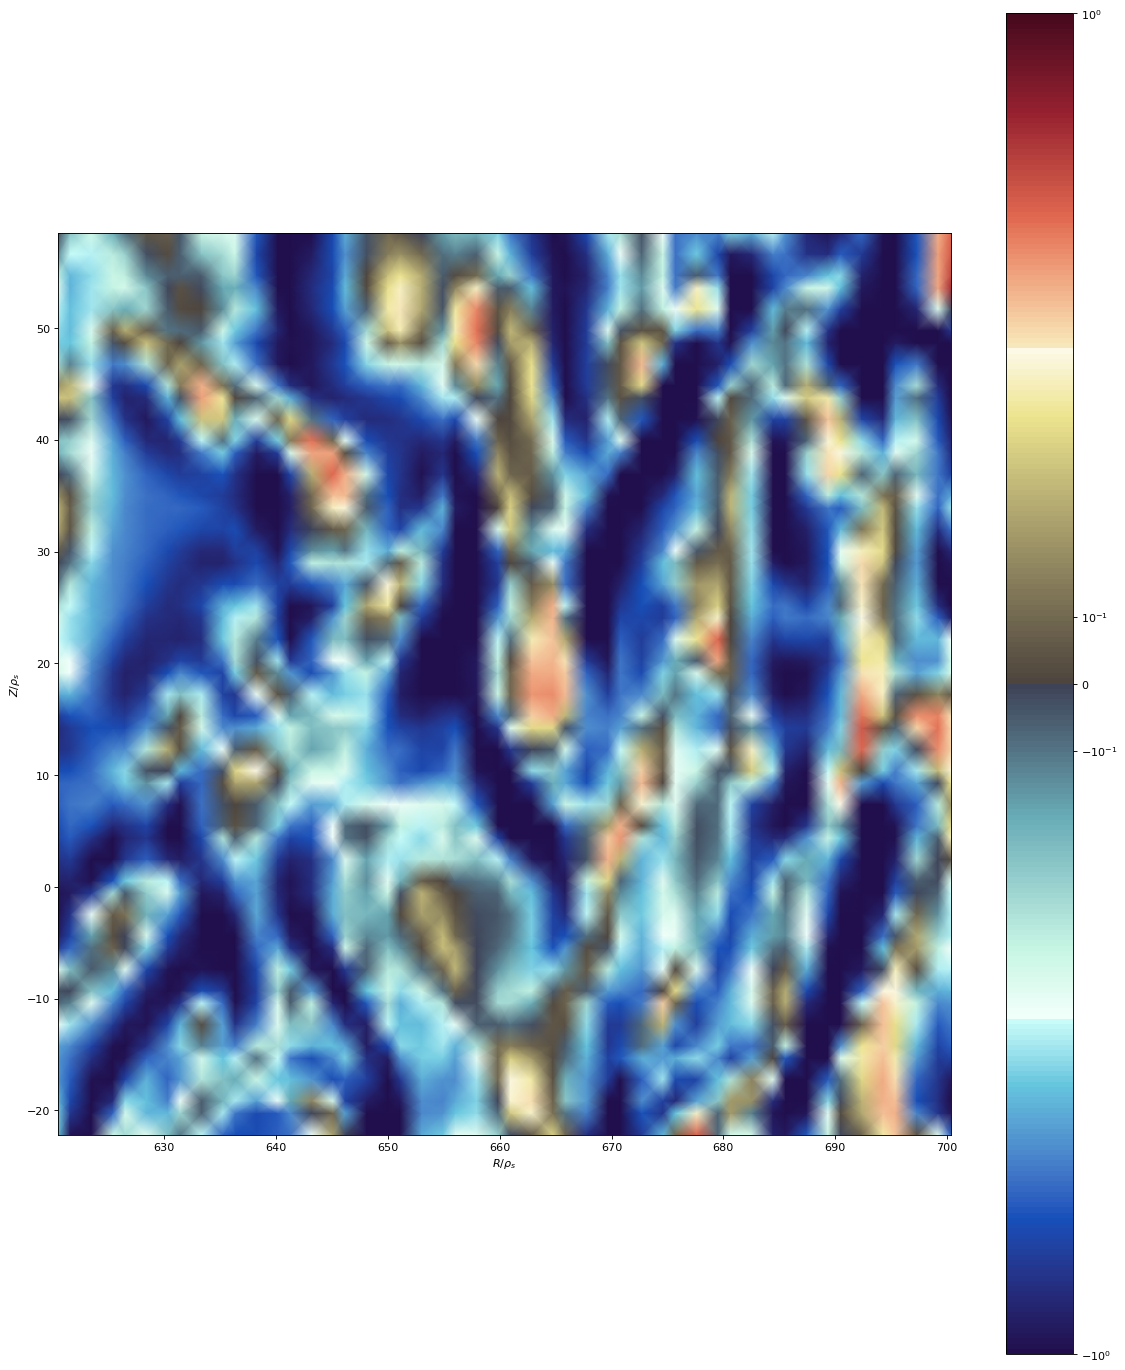

In [21]:
# Plotting Ue
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(2*3*3,3*2*3.7),dpi= 80, facecolor='w', edgecolor='k')

cmap = convert.xml2cmap( 'ccc-tool_colormap_Divergent 1.xml')
cmap = convert.xml2cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
current = -da['Ue_2d'][-1,:,:]*da['electrons_2d'][-1,:,:]+da['Ui_2d'][-1,:,:]*da['ions_2d'][-1,:,:]
pcm = ax.pcolormesh( da['x'][200:250], da['y'][250:300], current[250:300,200:250] ,
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.1, linscale=.1,
                                              vmin=-1, vmax=1, base=10),
                    
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap=cmap,
              rasterized=True)
# im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
#                 levels=[1,lvls[0]], linewidths=.5,colors='k')
# im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
#                 levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

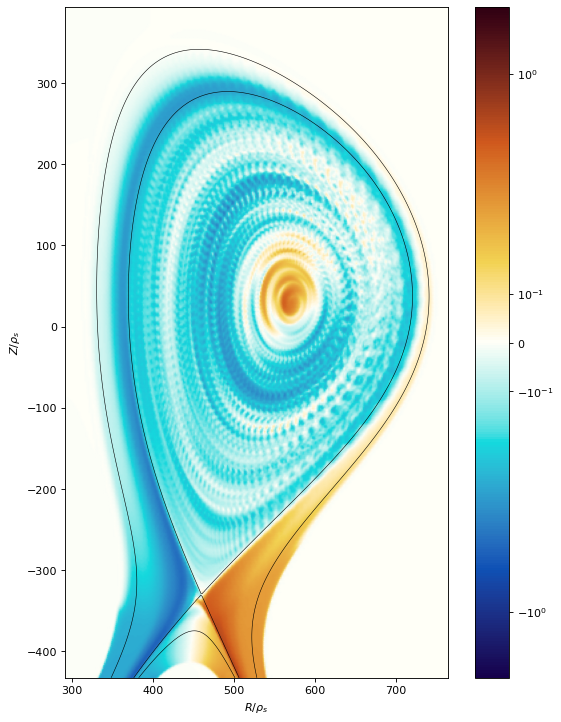

In [22]:
# Plotting NiUi
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

cmap=plt.get_cmap('twilight_shifted')
# cmap=plt.get_cmap('seismic')
# cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
cmap = convert.xml2cmap( 'ccc-tool_colormap_Divergent 1.xml')
pcm = ax.pcolormesh( da['x'], da['y'], da['niui_ta2d'][-1,:,:],
#                     vmin=-1., vmax=1.,
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.1, linscale=.2,
                                              vmin=-2, vmax=2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

0.0001


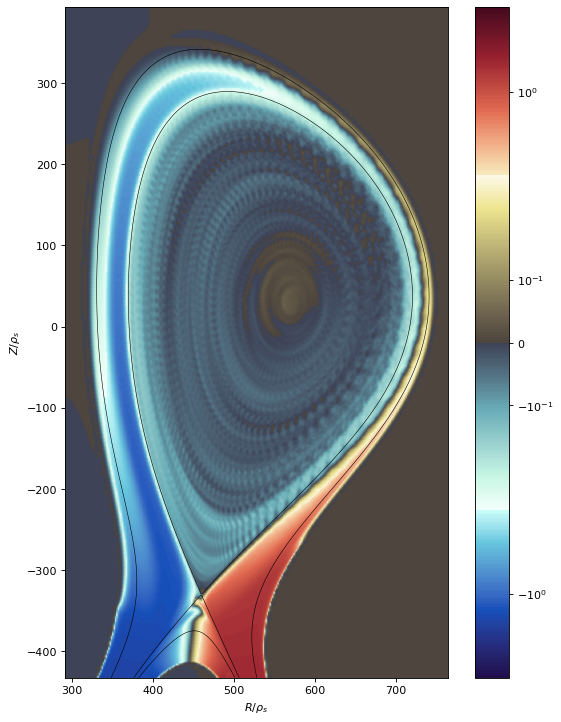

In [23]:
# Plotting Ui
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

cmap = convert.xml2cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
pcm = ax.pcolormesh( da['x'], da['y'], da['Ui_ta2d'][-1,:,:],
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.1, linscale=.3,
                                              vmin=-2.8, vmax=2.8, base=10),
                    
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
print(da.physical["resistivity"])
plt.show()

<xarray.DataArray 'time' ()>
array(100.)
0.0001


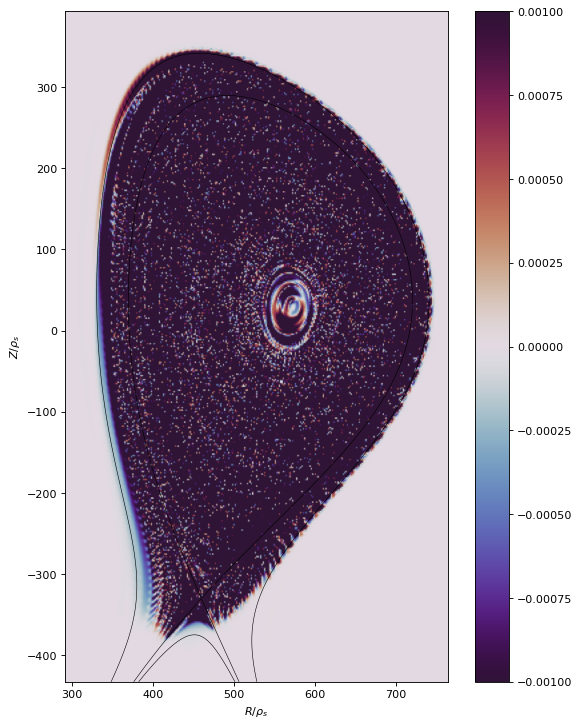

In [24]:
# Plotting NiUi
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
pcm = ax.pcolormesh( da['x'], da['y'],
#                     (da['sparsni_tt_2d'][last_idx,:,:]-da['Ui_2d'][last_idx,:,:]*da['sni_tt_2d'][last_idx,:,:])/da['ions_2d'][last_idx,:,:]
                    (da['Ui_ta2d'][-1,:,:]-da['Ui_ta2d'][-2,:,:])
                    +da['Ui_ta2d'][-2,:,:]*da['sni_tt_ta2d'][-1,:,:]/da['ions_ta2d'][-1,:,:]
#                     da['Ui_2d'][last_idx,:,:]/da['ions_2d'][last_idx,:,:]
#                     (da['ions_2d'][last_idx,:,:]-da['ions_2d'][last_idx-1,:,:])/100
#                     -da['sni_tt_2d'][last_idx,:,:]/100
                    ,
                vmin=-1e-3,vmax=1e-3,
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap='twilight_shifted',
              rasterized=True)
print((da['time'][last_idx]-da['time'][last_idx-1]))
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
print(da.physical["resistivity"])
plt.show()

In [25]:
# %matplotlib notebook
# fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')


# anim = da["Ui_2d"][:,:,:].feltor.animate2D(x="x", y="y",ax = ax, fps=50,
#                                           #                 norm=colors.CenteredNorm(),
#                 norm=colors.SymLogNorm(linthresh=.01, linscale=.1,
#                                               vmin=-2, vmax=2, base=10),
                    
#                 shading='auto', # more pixely
# #                 shading='gouraud',
# #                 cmap='seismic',
#                 cmap='twilight_shifted',
#               rasterized=True)
# # print(da["Rho_p"])
# im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
#                 levels=[1,lvls[0]], linewidths=.5,colors='k')
# im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
#                 levels=[lvls[1]], linewidths=.5,colors='k')
# ax.set_aspect('equal')
# ax.set_xlabel( r"$R/\rho_s$")
# ax.set_ylabel( r"$Z/\rho_s$")

# anim.save( "ui_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))

In [26]:
# %matplotlib notebook
# fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')


# anim = da["Ue_2d"][:,:,:].feltor.animate2D(x="x", y="y",ax = ax, fps=50,
#                 norm=colors.SymLogNorm(linthresh=.02, linscale=.1,
#                                               vmin=-10, vmax=10, base=10),
                    
#                 shading='auto', # more pixely
# #                 shading='gouraud',
# #                 cmap='seismic',
#                 cmap='twilight_shifted',
#               rasterized=True)
# # print(da["Rho_p"])
# im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
#                 levels=[1,lvls[0]], linewidths=.5,colors='k')
# im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
#                 levels=[lvls[1]], linewidths=.5,colors='k')
# ax.set_aspect('equal')
# ax.set_xlabel( r"$R/\rho_s$")
# ax.set_ylabel( r"$Z/\rho_s$")

# anim.save( "ue_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))

time <xarray.DataArray 'time' ()>
array(100000.)
Coordinates:
    time     float64 1e+05
Attributes:
    units:    $\Omega_{ci}^{-1}$
0.0001 1


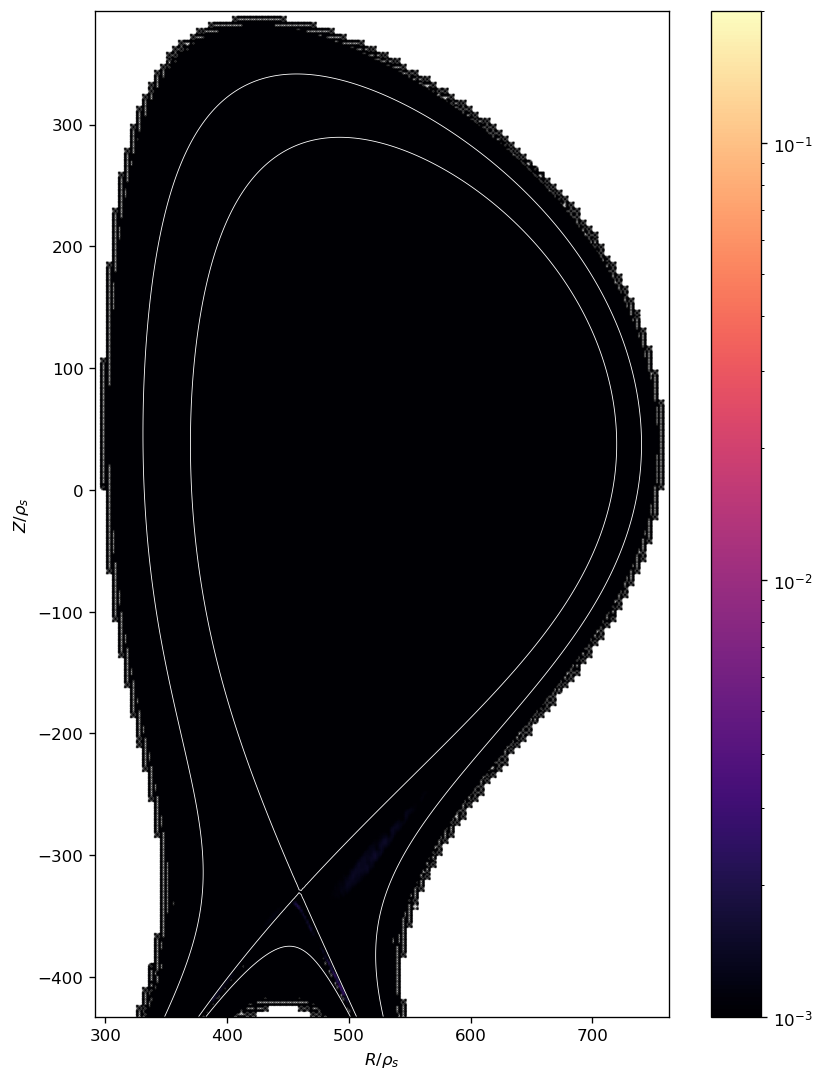

In [27]:
# Plotting Knudsen number
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 120, facecolor='w', edgecolor='k')
res = da.physical['resistivity']
print( "time", da['time'][-1])
pcm = ax.pcolormesh( da['x'], da['y'],
#                     np.abs(da['Ue_ta2d'][-1,:,:])
#   8.4e-3*da['lparallelinv_ta2d'][-1,:,:]/res/da['electrons_ta2d'][-1,:,:]
  2.5e-4*0.51*np.abs(da['Ui_ta2d'][-1,:,:])*da['lparallelinv_ta2d'][-1,:,:]/res/da['electrons_ta2d'][-1,:,:]
#  2.5e-4*0.51*da['lparallelinv_ta2d'][-1,:,:]/res/da['electrons_ta2d'][-1,:,:]
                    ,
                    norm=colors.LogNorm(1e-3,2e-1),
#                 vmin=0,vmax=0.15,
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap='magma',
              rasterized=True)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='w')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='w')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
res = da.physical["resistivity"]
tau = da.physical['tau']
print( res, tau)
plt.savefig( 'Knudsen-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()